## FLU trend season  
We'll define our forecasting task to have an 8-week horizon with a 1-week lead time. In other words, we'll be forecasting eight weeks of flu cases starting with the following week.

In [1]:
# Setup feedback system

# Setup notebook
from pathlib import Path
import ipywidgets as widgets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

comp_dir = Path('data/')
 
store_sales = pd.read_csv(comp_dir / 'train.csv', usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'], infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

print(" store_sales: \n",store_sales)

family_sales = (store_sales.groupby(['family', 'date']).mean().unstack('family').loc['2017'])

print(" family_sales: \n",family_sales)

test = pd.read_csv(comp_dir / 'test.csv', dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'], infer_datetime_format=True,)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

print(" test: \n",test)

 store_sales: 
                                      sales  onpromotion
store_nbr family     date                              
1         AUTOMOTIVE 2013-01-01   0.000000            0
                     2013-01-02   2.000000            0
                     2013-01-03   3.000000            0
                     2013-01-04   3.000000            0
                     2013-01-05   5.000000            0
...                                    ...          ...
9         SEAFOOD    2017-08-11  23.830999            0
                     2017-08-12  16.859001            4
                     2017-08-13  20.000000            0
                     2017-08-14  17.000000            0
                     2017-08-15  16.000000            0

[3000888 rows x 2 columns]
 family_sales: 
                 sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017

Consider the following three forecasting tasks:

1. 3-step forecast using 4 lag features with a 2-step lead time
2. 1-step forecast using 3 lag features with a 1-step lead time
3. 3-step forecast using 4 lag features with a 1-step lead time

Run the next cell to see three datasets, each representing one of the tasks above.

In [22]:
def load_multistep_data():
    df1 = create_multistep_example(10, steps=1, lags=3, lead_time=1)
    df2 = create_multistep_example(10, steps=3, lags=4, lead_time=2)
    df3 = create_multistep_example(10, steps=3, lags=4, lead_time=1)
    return [df1, df2, df3]

def make_lags(ts, lags, lead_time=1, name='y'):
    return pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

def make_multistep_target(ts, steps, reverse=False):
    shifts = reversed(range(steps)) if reverse else range(steps)
    return pd.concat({f'y_step_{i + 1}': ts.shift(-i) for i in shifts}, axis=1)


def create_multistep_example(n, steps, lags, lead_time=1):
    ts = pd.Series(
        np.arange(n),
        index=pd.period_range(start='2010', freq='A', periods=n, name='Year'),
        dtype=pd.Int8Dtype,
    )
    X = make_lags(ts, lags, lead_time)
    y = make_multistep_target(ts, steps, reverse=True)
    data = pd.concat({'Targets': y, 'Features': X}, axis=1)
    data = data.style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                     .set_properties(['Features'], **{'background-color': 'Lavender'})
    return data

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)


In [10]:
datasets = load_multistep_data()

data_tabs = widgets.Tab([widgets.Output() for _ in enumerate(datasets)])
for i, df in enumerate(datasets):
    data_tabs.set_title(i, f'Dataset {i+1}')
    with data_tabs.children[i]:
        display(df)

display(data_tabs)

## Match description to dataset

In [12]:
# YOUR CODE HERE: Match the task to the dataset. Answer 1, 2, or 3.
task_a=2# dataset 2
task_b=1# dataset 1
task_c=3# dataset 3​
# Check your answer
# q_1.check()

Look at the time indexes of the training and test sets. From this information, can you identify the forecasting task for Store Sales?

In [13]:
print("Training Data", "\n" + "-" * 13 + "\n", store_sales)
print("\n")
print("Test Data", "\n" + "-" * 9 + "\n", test)

Training Data 
-------------
                                      sales  onpromotion
store_nbr family     date                              
1         AUTOMOTIVE 2013-01-01   0.000000            0
                     2013-01-02   2.000000            0
                     2013-01-03   3.000000            0
                     2013-01-04   3.000000            0
                     2013-01-05   5.000000            0
...                                    ...          ...
9         SEAFOOD    2017-08-11  23.830999            0
                     2017-08-12  16.859001            4
                     2017-08-13  20.000000            0
                     2017-08-14  17.000000            0
                     2017-08-15  16.000000            0

[3000888 rows x 2 columns]


Test Data 
---------
                                       id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08

Try to identify the forecast origin and the forecast horizon. How many steps are within the forecast horizon? What is the lead time for the forecast?

The training set ends on 2017-08-15, which gives us the forecast origin. The test set comprises the dates 2017-08-16 to 2017-08-31, and this gives us the forecast horizon. There is one step between the origin and horizon, so we have a lead time of one day.

Put another way, we need a 16-step forecast with a 1-step lead time. We can use lags starting with lag 1, and we make the entire 16-step forecast using features from 2017-08-15.

##  Create multistep dataset for *Store Sales*
Create targets suitable for the *Store Sales* forecasting task. Use 4 days of lag features. Drop any missing values from both targets and features.

In [17]:
# YOUR CODE HERE
y = family_sales.loc[:, 'sales']

# YOUR CODE HERE: Make 4 lag features
X = make_lags(y,4).dropna()

# YOUR CODE HERE: Make multistep target
y = make_multistep_target(y, steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)

print(y.head())

print(X.head())

# Check your answer
# q_3.check()

             y_step_1                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   
2017-01-06   6.018518  0.277778   6.518518  3507.277832  0.537037   
2017-01-07  10.259259  0.259259  10.037037  4848.518555  0.481481   
2017-01-08   9.388889  0.240741  11.611111  5503.647949  0.722222   
2017-01-09   5.944445  0.444444   5.648148  3448.203613  0.500000   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   
2017-01-06   513.873291   18.333334  1257.611084   864.333313  317.622406   
2017-01-07   649.424133   21.444445  1761.351807  1173.463013 

Now, you'll apply the DirRec strategy to the multiple time series of Store Sales.

Make sure you've successfully completed the previous exercise and then run this cell to prepare the data for XGBoost.

In [18]:
le = LabelEncoder()
X = (X.stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

print(y.head())
print(X.head())

                          y_step_1     y_step_2     y_step_3     y_step_4  \
date       family                                                           
2017-01-05 AUTOMOTIVE     6.333333     6.018518    10.259259     9.388889   
           BABY CARE      0.351852     0.277778     0.259259     0.240741   
           BEAUTY         5.925926     6.518518    10.037037    11.611111   
           BEVERAGES   3258.796387  3507.277832  4848.518555  5503.647949   
           BOOKS          0.407407     0.537037     0.481481     0.722222   

                          y_step_5     y_step_6     y_step_7     y_step_8  \
date       family                                                           
2017-01-05 AUTOMOTIVE     5.944445     4.777778     6.314815     5.388889   
           BABY CARE      0.444444     0.240741     0.277778     0.296296   
           BEAUTY         5.648148     6.500000     5.277778     4.370370   
           BEVERAGES   3448.203613  3171.740723  3046.870361  2693.722168  

## Forecast with the DirRec strategy

NameError: name 'sns' is not defined

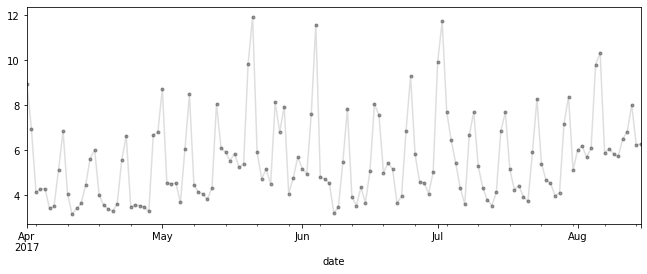

In [23]:
from sklearn.multioutput import RegressorChain

# YOUR CODE HERE
model = RegressorChain(base_estimator=XGBRegressor())

# Check your answer
# q_4.check()

model.fit(X, y)

y_pred = pd.DataFrame(
    model.predict(X),
    index=y.index,
    columns=y.columns,
).clip(0.0)
FAMILY = 'BEAUTY'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])
